# Library Import 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# Preparing the data 
## Loading Data from HDF5

In [2]:
database_path = "data/crypto_database.h5"

# Define the date range for the last half of January 2020
start_date = '2019-01-01'
end_date = '2019-05-01'

df = pd.read_hdf(database_path, key="BTCUSDT", where=f"index >= '{start_date}' and index <= '{end_date}'")

## Data Cleaning and Preprocessing

In [3]:
# Check for missing values
print(df.isnull().sum())

# Convert 'Open_Time' to datetime if not already done
df.reset_index(inplace=True)
df['Open_Time'] = pd.to_datetime(df['Open_Time'])

# Set 'Open_Time' as the index
df.set_index('Open_Time', inplace=True)

Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Quote_Asset_Volume              0
Number_of_Trades                0
Taker_Buy_Base_Asset_Volume     0
Taker_Buy_Quote_Asset_Volume    0
Ignore                          0
dtype: int64


## Taking a look at the data

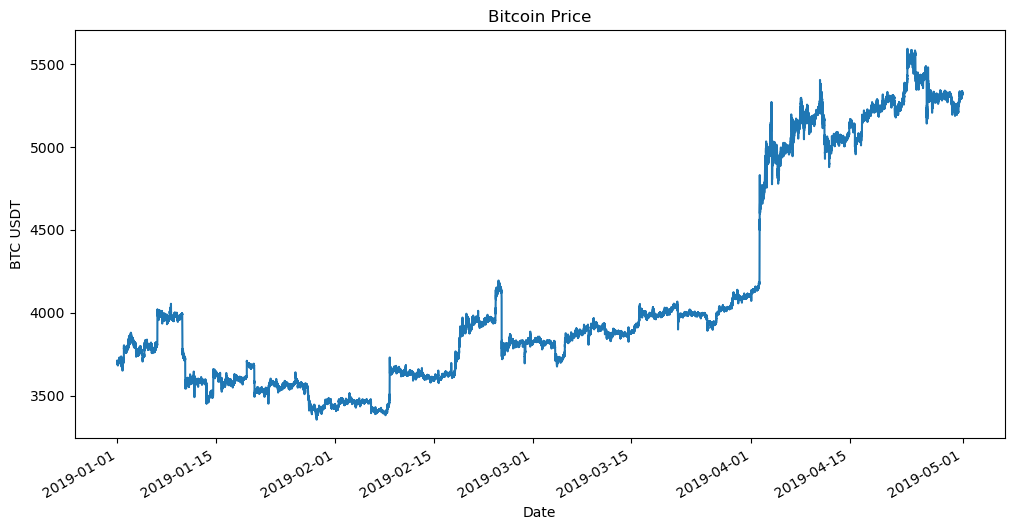

In [4]:
# Plot the log returns
plt.figure(figsize=(12, 6))
df['Close'].plot()
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('BTC USDT')
plt.show()

## Calculating log returns 

In [5]:
# Calculate log returns
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop the NaN value created by the shift
df.dropna(subset=['log_returns'], inplace=True)

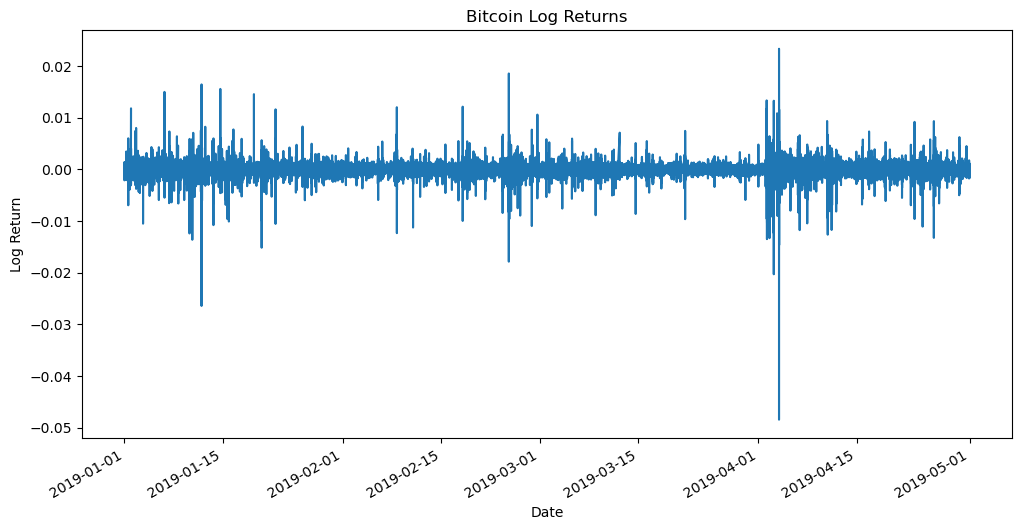

In [6]:
# Plot the log returns
plt.figure(figsize=(12, 6))
df['log_returns'].plot()
plt.title('Bitcoin Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# Testing for ARCH Effects 
## Stationarity Test 

Before testing for ARCH effects, we must first check if the series is stationary. A stationary series has a constant mean and variance over time, which is important for applying time series models like GARCH.

To test for stationarity, we typically use the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the series has a unit root, i.e., it is non-stationary.

In [7]:
split_date = pd.to_datetime("2019-04-01")
training_data_mask = df.index < split_date
returns = df.loc[training_data_mask, 'log_returns']

In [8]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(returns)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -53.002111501058444
p-value: 0.0


The p-value is less than 0.05, the series is stationary.

## Autocorrelation Test 

Once stationarity is confirmed, we check for autocorrelation in the squared returns. The presence of autocorrelation in squared returns indicates volatility clustering, a key sign of ARCH effects.

To test for autocorrelation, we can use the Ljung-Box Q-test. This test checks for autocorrelation at

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Check autocorrelation in squared returns
ljung_box_test = acorr_ljungbox(returns**2, lags=[10], return_df=True)

print(ljung_box_test)

         lb_stat  lb_pvalue
10  34331.948673        0.0


A significant p-value (below 0.05) for the Ljung-Box test means that there is significant autocorrelation in the squared returns, suggesting the presence of ARCH effects.

## Normality check 

In [13]:
from scipy.stats import jarque_bera

# Perform Jarque-Bera test on returns
jb_test_stat, jb_p_value = jarque_bera(returns)

print(f'Jarque-Bera Test Statistic: {jb_test_stat}')
print(f'P-value: {jb_p_value}')

Jarque-Bera Test Statistic: 85728124.76566969
P-value: 0.0


A p-value lower than 0.05 indicates that we reject the null hypothesis, implying that the returns do not follow a normal distribution. This further strengthens the case for using models like GARCH, which can handle non-normal characteristics such as fat tails and volatility clustering.

#  Model Selection 

In [14]:
from arch import arch_model

In [15]:
scaling_factor = 60*24 # We get daily returns

In [21]:
min_bic = 1e10
selected_orders = (0, 0)
for p in range(1, 4):
    for q in range(0, 4):
        # GARCH(p,q) model
        model = arch_model(
            df['log_returns']*scaling_factor, 
            mean='Zero', 
            vol='GARCH', 
            p=p, q=q
            )
        res = model.fit(disp='off', last_obs=split_date,)
        print(f'GARCH({p},{q}) AIC: {res.aic}, BIC: {res.bic}')
        if res.bic < min_bic:
            min_bic = res.bic
            selected_orders = (p, q)
p, q = selected_orders
print(f'Selected model with BIC : p={p} and q={q}')

GARCH(1,0) AIC: 269793.01931055624, BIC: 269812.558147921
GARCH(1,1) AIC: 245265.1323021801, BIC: 245294.44055822722
GARCH(1,2) AIC: 244480.07736779848, BIC: 244519.15504252794
GARCH(1,3) AIC: 244168.23045229167, BIC: 244217.0775457035
GARCH(2,0) AIC: 260475.38690308636, BIC: 260504.69515913347
GARCH(2,1) AIC: 245268.00954894855, BIC: 245307.087223678
GARCH(2,2) AIC: 244482.07737045927, BIC: 244530.9244638711
GARCH(2,3) AIC: 244170.230456519, BIC: 244228.8469686132
GARCH(3,0) AIC: 255222.99234444185, BIC: 255262.0700191713
GARCH(3,1) AIC: 245269.1326656593, BIC: 245317.97975907114
GARCH(3,2) AIC: 244484.07805419483, BIC: 244542.69456628902
GARCH(3,3) AIC: 244172.23049541027, BIC: 244240.61642618684
Selected model with BIC : p=1 and q=3


We select the GARCH(2, 3) model because it has the lowest AIC and BIC.

In [48]:
# GARCH(1, 3) model
model = arch_model(df['log_returns'] * scaling_factor, mean='Zero', vol='GARCH', p=p, q=q)
res = model.fit(last_obs=split_date, disp='off')
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -122079.
Distribution:                  Normal   AIC:                           244168.
Method:            Maximum Likelihood   BIC:                           244217.
                                        No. Observations:               129239
Date:                Thu, Sep 26 2024   Df Residuals:                   129239
Time:                        12:01:08   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0180  3.464e-03      5.200  1.991e-07 [1.

# Goodness-of-fit check

After fitting our selected GARCH model, it is highly recommended to perform a **goodness-of-fit check** on the residuals to ensure that the model adequately captures the dynamics of your time series. The main goal of such checks is to assess whether the model residuals behave as expected—ideally, they should resemble white noise, meaning they have no autocorrelation and constant variance (homoscedasticity).

In [ ]:
# Standardized residuals from the GARCH model
std_residuals = res.resid / res.conditional_volatility
# Because of the last obs arguments we have NaNs
std_residuals = std_residuals.dropna() 

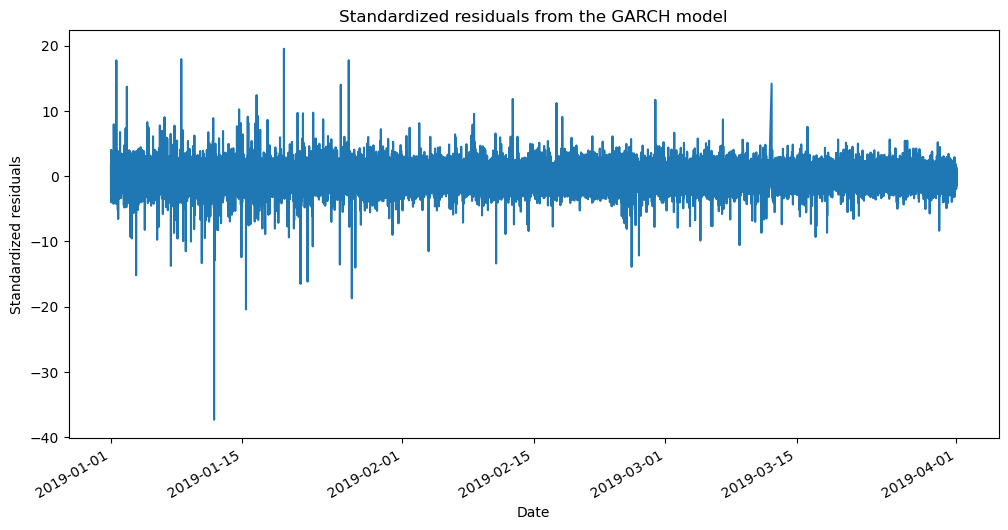

In [54]:
# Plot the standardized residuals from the GARCH model
plt.figure(figsize=(12, 6))
std_residuals.plot()
plt.title('Standardized residuals from the GARCH model')
plt.xlabel('Date')
plt.ylabel('Standardized residuals')
plt.show()

## Autocorrelation of Residuals

After fitting the GARCH model, the standardized residuals (the residuals divided by their estimated volatility) should no longer show any significant autocorrelation. We can here again use the **Ljung-Box Q-test** to test whether there is any remaining autocorrelation in the residuals or squared residuals.

In [50]:
# Ljung-Box test for residuals (no autocorrelation should be present)
ljung_box_res = acorr_ljungbox(std_residuals, lags=[10], return_df=True)
print('Ljung-Box test for residuals')
print(ljung_box_res)

# Ljung-Box test for squared residuals (no remaining ARCH effects should be present)
ljung_box_sq_res = acorr_ljungbox(std_residuals**2, lags=[10], return_df=True)
print('Ljung-Box test for squared residuals')
print(ljung_box_sq_res)

Ljung-Box test for residuals
       lb_stat     lb_pvalue
10  163.434818  6.326210e-30
Ljung-Box test for squared residuals
      lb_stat  lb_pvalue
10  19.082143   0.039232


## Normality of Residuals 

We also check whether the residuals follow a normal distribution.  
The **Jarque-Bera test** can be used for this:

In [51]:
from scipy.stats import jarque_bera

# Perform Jarque-Bera test on standardized residuals
jb_stat, jb_p_value = jarque_bera(std_residuals)
print(f'Jarque-Bera Test Statistic: {jb_stat}')
print(f'P-value: {jb_p_value}')

Jarque-Bera Test Statistic: 5551677.823833454
P-value: 0.0


A p-value lower than 0.05 indicates that we reject the null hypothesis, implying that the returns do not follow a normal distribution. This further strengthens the case for using models like GARCH, which can handle non-normal characteristics such as fat tails and volatility clustering.

# Estimating and Forecasting Volatility 
## Estimating Volatility 

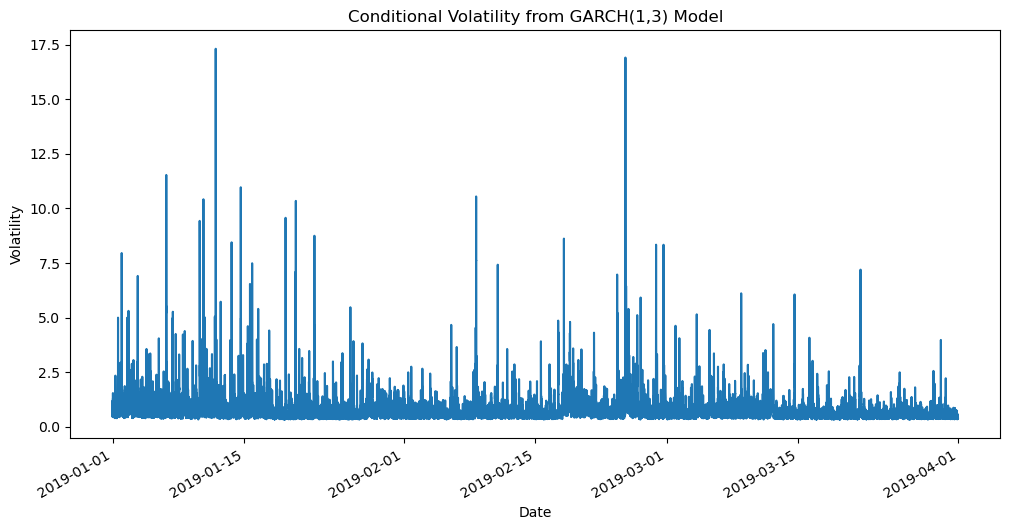

In [66]:
# Get conditional volatility
cond_vol = res.conditional_volatility
cond_vol.dropna(inplace=True)

# Plot the conditional volatility
plt.figure(figsize=(12, 6))
cond_vol.plot()
plt.title(f'Conditional Volatility from GARCH({p},{q}) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

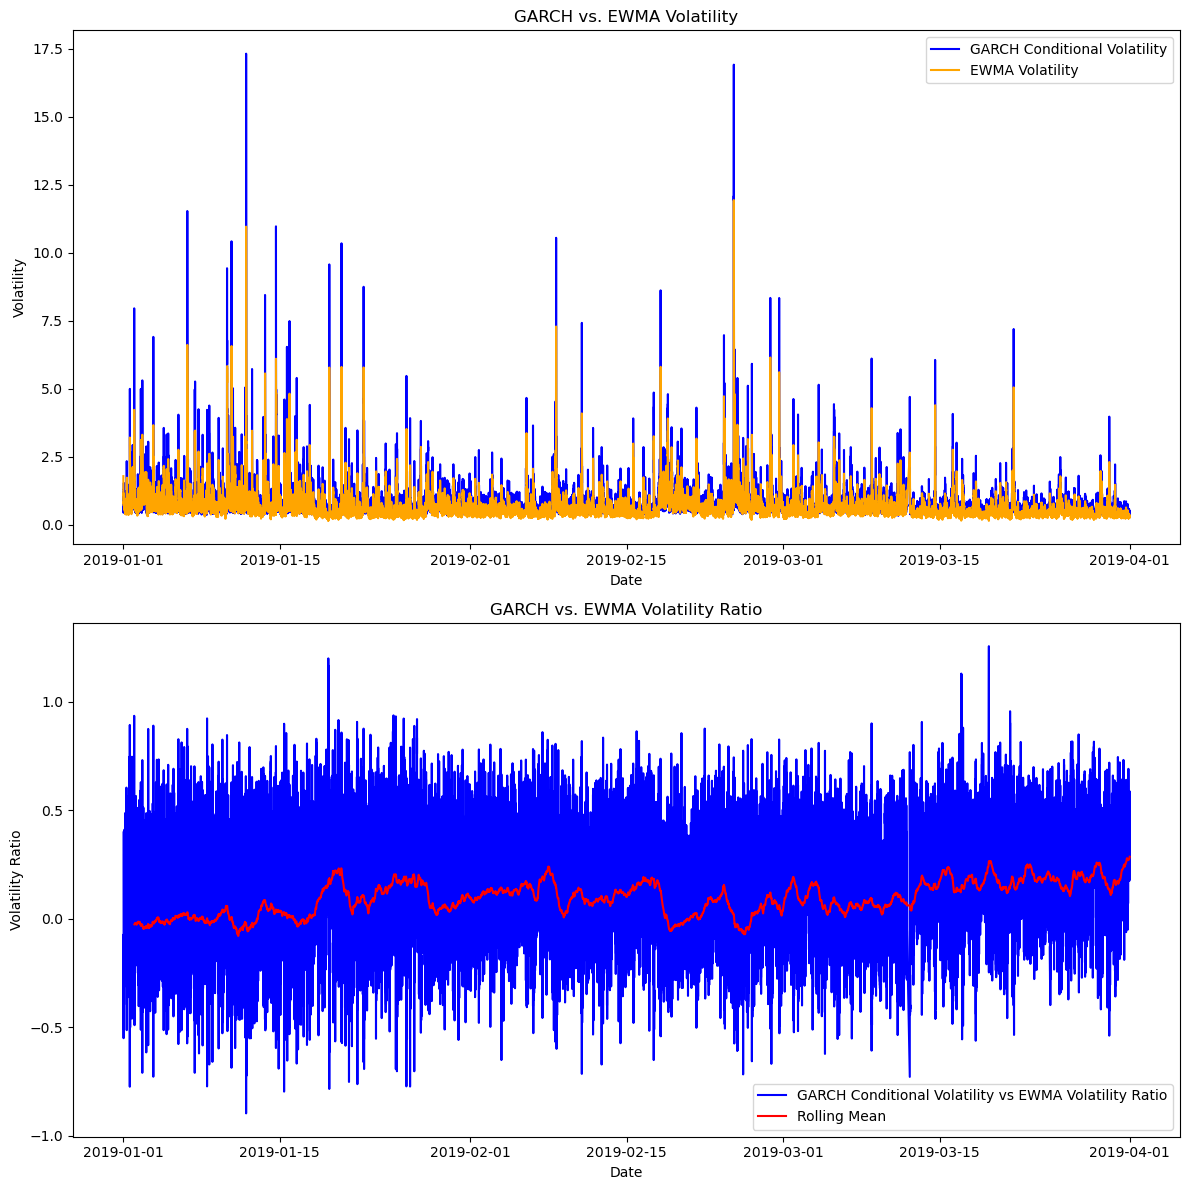

In [95]:
# Compute EWMA volatility
lambda_ = 0.94  # Decay factor as used in RiskMetrics
ewma_vol = (scaling_factor*returns).ewm(alpha=(1 - lambda_), adjust=False).std()

# Create a figure with two subplots (2 rows, 1 column)
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# First subplot: GARCH vs EWMA Volatility
axs[0].plot(cond_vol, label='GARCH Conditional Volatility', color='blue')
axs[0].plot(ewma_vol, label='EWMA Volatility', color='orange')
axs[0].set_title('GARCH vs. EWMA Volatility')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Volatility')
axs[0].legend()

# Second subplot: GARCH vs EWMA Volatility Ratio
axs[1].plot((cond_vol - ewma_vol) / ewma_vol, label='GARCH Conditional Volatility vs EWMA Volatility Ratio', color='blue')
axs[1].plot(((cond_vol - ewma_vol) / ewma_vol).rolling(60*24).mean(), label='Rolling Mean', color='red')
axs[1].set_title('GARCH vs. EWMA Volatility Ratio')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volatility Ratio')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# Display the figure
plt.show()

## Forecasting Volatility

In [100]:
forecasts = res.forecast(horizon=60, start=split_date)
forecasted_variance = forecasts.variance
forecasted_volatility = np.sqrt(forecasted_variance)    

# Plot the conditional volatility
plt.figure(figsize=(12, 6))
forecasted_volatility["h.60"].plot()
plt.title(f'Forecast Volatility from GARCH({p},{q}) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

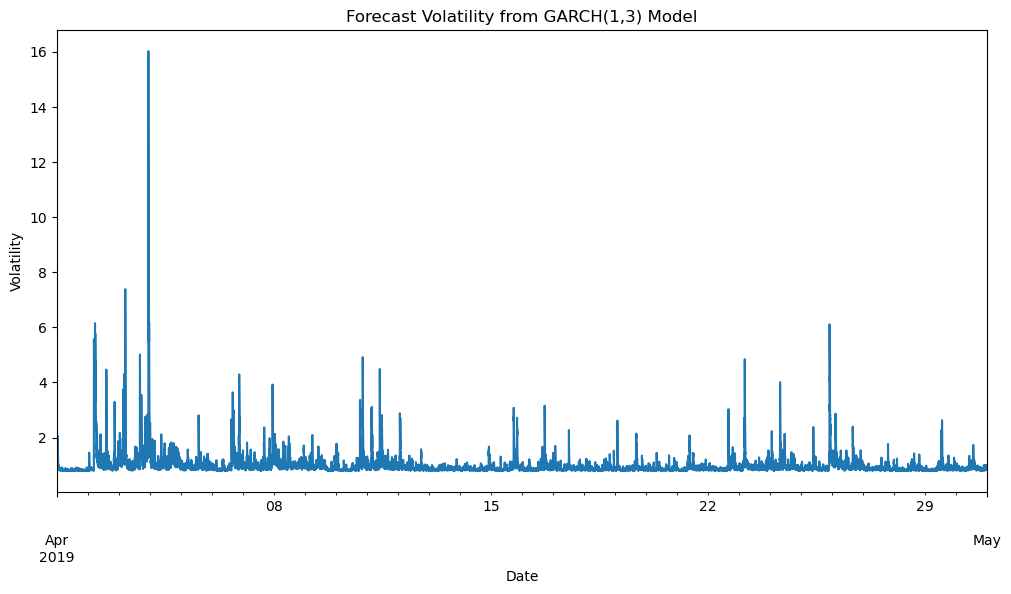

In [102]:
# Plot the conditional volatility
plt.figure(figsize=(12, 6))
forecasted_volatility["h.60"].plot()
plt.title(f'Forecast Volatility from GARCH({p},{q}) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()